<a href="https://colab.research.google.com/github/utkarshsharma1/ECG_Signals/blob/master/1d_all_classifier_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [ ]:
!pip install wfdb
import wfdb              # much needed for annotations


!pip install biosppy
from biosppy.signals import ecg
from scipy import signal

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 163kB 7.0MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=8cd0ad32e3418a3679d6c05aadd17726c0890d5b14e5b6d67f8f7f031ae5f6a8
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb
     |████████████████████████████████| 81kB 2.5MB/s 


In [ ]:
sample_database = ['100', '101', '102', '103', '104', '105', '106', '107', '108', 
                   '109', '111', '112', '113', '114', '115', '116', '117', '118',
                   '119', '121', '122', '123', '124', '200', '201', '202', '203',
                   '205', '207', '208', '209', '210', '212', '213', '214', '215',
                   '217', '219', '220', '221', '222', '223', '228', '230', '231',
                   '232', '233', '234']

#abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']
abnormal = ['L', 'R', 'V', '/']

In [ ]:
def load_ecg_signal(file):
    
    record = wfdb.rdrecord(file, pb_dir= 'mitdb')
    annotation = wfdb.rdann(file, 'atr', pb_dir= 'mitdb')
    
    #This gives signal
    p_signal = record.p_signal
    
    assert record.fs == 360, 'Sample frequency is not 360'
    
    #This gives symbols & annotation index
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_symbol, atr_sample

In [ ]:
def make_dataset(sample_database, no_of_sec, fs):
    
    #No of columns
    num_cols = 2 * no_of_sec * fs
    X_all = np.zeros((1, num_cols))
    Y_all = np.zeros((1,1))
    symbol_all = []
    
    max_rows = []
    
    for i in sample_database:
        #file = path + i
        print(i)
        p_signal, atr_symbol, atr_sample = load_ecg_signal(i)
        
        #Take out first signal as there are 2 signals
        p_signal = p_signal[:,0]
        
        #Make a dataframe to exclude irrevalent atr_symbol
        #atr_sample is index of annotation
        df_annotation = pd.DataFrame({'atr_symbol': atr_symbol,'atr_sample': atr_sample})
        df_annotation = df_annotation.loc[df_annotation.atr_symbol.isin(abnormal + ['N'])]
        
        #Gives no of accepted pulses
        no_of_rows = len(df_annotation)
        
        #creates matrix accordingly
        X = np.zeros((no_of_rows, num_cols))
        Y = np.zeros((no_of_rows, 1))
        
        #keep track of rows
        row_number = 0
        
        #Now iterate through the dataframe
        for atr_sample, atr_symbol in zip(df_annotation.atr_sample.values, df_annotation.atr_symbol.values):
            
            #Took min and max value in order to tackle the 2 extreme end cases
            left = max([0, (atr_sample - no_of_sec * fs)])
            right = min([len(p_signal), (atr_sample + no_of_sec * fs)])
            x = p_signal[left: right]
            
            if len(x) == num_cols:
            
                #This will store all the values of p_signal from 'left' to 'right'
                X[row_number, :] = x
                
                #This line will store 0 if its normal & 1 if its abnormal in Y
                if(atr_symbol in abnormal):
                  Y[row_number, :] = abnormal.index(atr_symbol) + 1
                else:
                  Y[row_number, :] = 0
                
                #A list consisting of all symbols
                symbol_all.append(atr_symbol)
                row_number += 1
                
        #Reduces rows of X and Y as we remove some datas whose len(x) != num_cols
        X = X[: row_number, :]
        Y = Y[: row_number, :]
                
        #For checking dimensions       
        max_rows.append(row_number)
                
        #append X and Y from previous iteration with new data
        X_all = np.append(X_all, X, axis = 0)
        Y_all = np.append(Y_all, Y, axis = 0)
     
    #Removes first column as it contains only zeros when we initialized it
    X_all = X_all[1:, :]
    Y_all = Y_all[1:, :]
            
    
    assert np.sum(max_rows) == X_all.shape[0], 'No of rows messed 1'
    assert Y_all.shape[0] == X_all.shape[0], 'No of rows messed 2' 
    assert Y_all.shape[0] == len(symbol_all), 'No of rows messed 3'
            
    return X_all, Y_all, symbol_all

In [ ]:
#Lets keep no_of_sec as -+ of 3
no_of_sec = 1
#sampling frequency is 360
fs = 94
X_all, Y_all, Symbol_all = make_dataset(sample_database, no_of_sec, fs)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [ ]:
print(X_all.shape, Y_all.shape, len(Symbol_all))

(104518, 188) (104518, 1) 104518


Y value :  [3.]


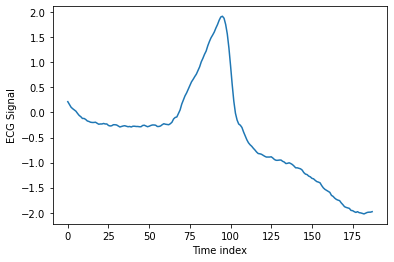

In [ ]:
plt.plot(X_all[80988])
plt.xlabel('Time index')
plt.ylabel('ECG Signal')
plt.show
print('Y value : ', Y_all[80988])